In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from astropy import constants as const
import tables
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator
import glob
from astropy.table import Table

In [2]:
def Gaussian(wv, wv0, sigma, intensity):
    return intensity / (np.sqrt(2. * np.pi) * sigma) *\
           np.exp(-0.5 * ((wv - wv0) / sigma)**2)


def OneGaussianModel(wv, a, b, wv_cen, sigma, intensity):
    return (a * wv + b) * (1 - Gaussian(wv, wv_cen, sigma, intensity))

    
def MultiGaussianModel(wv, a, b, wv_cen_list, sigma_list, intensity_list):
    flux = a * wv + b
    for wv_cen, sigma, intensity in zip(wv_cen_list, sigma_list, intensity_list):
        flux *= (1 - Gaussian(wv, wv_cen, sigma, intensity))
    return flux


def TwoGaussianModel(wv, a, b, wv_cen1, sigma1, intensity1, wv_cen2, sigma2, intensity2):
    return MultiGaussianModel(wv, a, b, [wv_cen1, wv_cen2], [sigma1, sigma2], [intensity1, intensity2])


def FitSpec(spec, model, p0, lambda_range=None):
    if lambda_range is None:
        lambda_range = [spec.data["wavelength"].min(), spec.data["wavelength"].max()]
    idx = np.logical_and(spec.data["wavelength"] >= lambda_range[0],
                         spec.data["wavelength"] <= lambda_range[1])
    wv = spec.data["wavelength"][idx]
    flx = spec.data["flux"][idx]
    popt, pcov = curve_fit(model, wv, flx, p0=p0)
    return popt, pcov

In [3]:
class Spectroscopy(object):
    
    def __init__(self, MJD, telescope, instrument, data, z=0):
        self.MJD = MJD
        self.telescope = telescope
        self.instrument = instrument
        self.data = data
        self.data["wavelength"] /= (1 + z)
        idx = np.logical_and(self.data["wavelength"] > 6000,
                             self.data["wavelength"] < 7000)
        self.data["flux"] /= np.median(self.data["flux"][idx])
        
    def __gt__(self, other):
        return self.MJD > other.MJD
    
    def __lt__(self, other):
        return self.MJD < other.MJD
    
    def __eq__(self, other):
        return self.MJD == other.MJD
    
    def __ge__(self, other):
        return self > other or self == other
    
    def __le__(self, other):
        return self < other or self == other
    
    def plot(self, ax, offset=0, **keywords):
        ax.plot(self.data["wavelength"], 
                self.data["flux"] + offset, 
                **keywords)
    

# load light curve data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table_group = h5file.root.spectroscopy
z = 0.0234
T_MAX = 57499.54

spectra = list()
for table in table_group:
    spec = np.array([(row["wavelength"], row["flux_lambda"])
                     for row in table],
                    dtype=[("wavelength", "f"), ("flux", "f")])
    
    spectra.append(Spectroscopy(table.attrs.OBS_DATE, 
                                table.attrs.TELESCOPE,
                                table.attrs.INSTRUMENT,
                                spec,
                                z=z))
spectra.sort()

# colors dictionary
aam_colors = {'mustard': "#E29930",
             'blue': "#217CA3",
             'asphalt': "#32384D"
             }

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


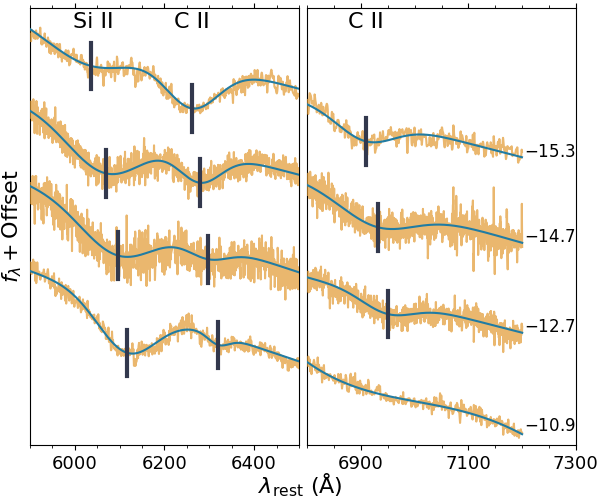

Si II 6355: center=6037.1 +/- 2.6, sigma=96.8 +/- 5.2, intensity=23.7 +/- 2.5
C II 6580: center=6261.8 +/- 1.0, sigma=59.4 +/- 1.0, intensity=22.3 +/- 0.5
C II 7234: center=6909.9 +/- 1.6, sigma=52.0 +/- 2.7, intensity=10.2 +/- 0.8
Si II 6355: center=6069.5 +/- 1.1, sigma=84.0 +/- 2.2, intensity=31.0 +/- 1.2
C II 6580: center=6279.0 +/- 1.2, sigma=48.1 +/- 1.1, intensity=12.5 +/- 0.3
C II 7234: center=6931.3 +/- 2.9, sigma=66.8 +/- 4.8, intensity=13.7 +/- 1.7
Si II 6355: center=6096.1 +/- 1.7, sigma=81.7 +/- 3.0, intensity=26.4 +/- 1.3
C II 6580: center=6296.7 +/- 3.6, sigma=45.3 +/- 3.5, intensity=5.7 +/- 0.5
C II 7234: center=6950.0 +/- 1.8, sigma=46.9 +/- 2.3, intensity=6.1 +/- 0.4
Si II 6355: center=6117.2 +/- 1.0, sigma=65.1 +/- 1.4, intensity=24.3 +/- 0.6
C II 6580: center=6320.0 +/- 2.9, sigma=24.3 +/- 3.0, intensity=2.1 +/- 0.3
C II 7234: center=6791.5 +/- 15.1, sigma=391.9 +/- 125.9, intensity=548.0 +/- 342.9


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6,5))

# initial guesses
p0_1 = [[0, 0, 6000, 100, 10, 6250, 50, 20], 
        [0, 0, 6100, 50, 0.1, 6250, 50, 0.2],
        [0, 0, 6100, 50, 0.1, 6280, 50, 0.2],
        [0, 0, 6100, 50, 0.1, 6280, 50, 0.2]]
p0_2 = [[0, 0, 6900, 50, 0.1],
        [0, 0, 6900, 50, 0.1],
        [0, 0, 6900, 50, 0.1],
        [0, 0, 6900, 50, 0.1]]

offset = 0
i = 0
center_wavelengths = list()
pEWs = list()
phases = list()
for spec in spectra[1:5]:
    # fit Si II and C II
    wv = spec.data["wavelength"]
    flx = spec.data["flux"]
    idx = np.logical_and(wv > 5900, wv < 6550)
    ax1.plot(wv[idx], flx[idx] / np.median(flx[idx]) + offset, color=aam_colors["mustard"], alpha=0.7, zorder=3)
    popt, pcov = FitSpec(spec, 
                         TwoGaussianModel, 
                         p0_1[i], 
                         lambda_range=[5900, 6550])
    model_flx = TwoGaussianModel(wv[idx], *popt)
    ax1.plot(wv[idx], model_flx / np.median(model_flx) + offset, color=aam_colors["blue"], zorder=5)
    
    # Si II 6355
    center = popt[2]
    center_err = pcov[2][2]**0.5
    width = popt[3]
    width_err = pcov[3][3]**0.5
    intensity = popt[4]
    intensity_err = pcov[4][4]**0.5
    center_measure = [(center, center_err)]
    pEW_measure = [(intensity, intensity_err)]
    print("Si II 6355: center={:.1f} +/- {:.1f}, sigma={:.1f} +/- {:.1f}, intensity={:.1f} +/- {:.1f}".format(
        center, center_err, width, width_err, intensity, intensity_err))
    
    # C II 6580
    center = popt[5]
    center_err = pcov[5][5]**0.5
    width = popt[6]
    width_err = pcov[6][6]**0.5
    intensity = popt[7]
    intensity_err = pcov[7][7]**0.5
    center_measure.append((center, center_err))
    pEW_measure.append((intensity, intensity_err))
    print("C II 6580: center={:.1f} +/- {:.1f}, sigma={:.1f} +/- {:.1f}, intensity={:.1f} +/- {:.1f}".format(
        center, center_err, width, width_err, intensity, intensity_err))
    
    #plot line centers
    line_flx = TwoGaussianModel(popt[2], *popt) / np.median(model_flx) + offset
    ax1.plot([popt[2], popt[2]],[line_flx-.08, line_flx+.08], color = aam_colors['asphalt'], lw = 3, zorder = 10)
    line_flx = TwoGaussianModel(popt[5], *popt) / np.median(model_flx) + offset
    ax1.plot([popt[5], popt[5]],[line_flx-.08, line_flx+.08], color = aam_colors['asphalt'], lw = 3, zorder = 10)

        
    # fit C II
    idx = np.logical_and(wv > 6800, wv < 7200)
    ax2.plot(wv[idx], flx[idx] / np.median(flx[idx]) + offset - 0.2, color=aam_colors['mustard'], alpha=0.7, zorder=3)
    popt, pcov = FitSpec(spec, 
                         OneGaussianModel, 
                         p0_2[i], 
                         lambda_range=[6800, 7200])
    model_flx = OneGaussianModel(wv[idx], *popt)
    model_flx /= np.median(model_flx)
    ax2.plot(wv[idx], model_flx + offset - 0.2, color=aam_colors['blue'], alpha=1, zorder=5)
    
    # C II 7234
    center = popt[2]
    center_err = pcov[2][2]**0.5
    width = popt[3]
    width_err = pcov[3][3]**0.5
    intensity = popt[4]
    intensity_err = pcov[4][4]**0.5
    center_measure.append((center, center_err))
    pEW_measure.append((intensity, intensity_err))
    print("C II 7234: center={:.1f} +/- {:.1f}, sigma={:.1f} +/- {:.1f}, intensity={:.1f} +/- {:.1f}".format(
        center, center_err, width, width_err, intensity, intensity_err))

    #plot line centers
    line_flx = OneGaussianModel(popt[2], *popt) / np.median(OneGaussianModel(wv[idx], *popt)) + offset - 0.2
    ax2.plot([popt[2], popt[2]],[line_flx-.08, line_flx+.08], color = aam_colors['asphalt'], lw = 3, zorder = 10)
    
    # phase info
    ax2.text(wv[idx][-1] + 3, np.median(model_flx[-20:-1]) + offset - 0.2,
             "$%+5.1f$" % ((spec.MJD - T_MAX)/(1+z)), fontsize=12)
    
    center_wavelengths.append(center_measure)
    pEWs.append(pEW_measure)
    phases.append((spec.MJD - T_MAX)/(1+z))
    i += 1
    offset -= 0.3

ax1.set_xlim(5900, 6500)
ax2.set_xlim(6800, 7200)
ax1.set_ylim(-0.25, 1.25)
ax2.set_ylim(-0.25, 1.25)
ax1.set_xticks(range(6000, 6600, 200))
ax2.set_xticks(range(6900, 7350, 200))
ax1.set_yticks([])
ax2.set_yticks([])
ax1.xaxis.set_minor_locator(MultipleLocator(50))
ax2.xaxis.set_minor_locator(MultipleLocator(50))

ax1.text(6040, 1.2, "Si II",
         fontsize=16,
         horizontalalignment="center",
         verticalalignment="center")
ax1.text(6260, 1.2, "C II",
         fontsize=16,
         horizontalalignment="center",
         verticalalignment="center")
ax2.text(6910, 1.2, "C II",
         fontsize=16,
         horizontalalignment="center",
         verticalalignment="center")

ax1.set_ylabel(r"$f_\lambda + \mathrm{Offset}$", fontsize = 16)
fig.text(0.5, 0.03, "$\lambda_\mathrm{rest}$ ($\\rm{\\AA}$)", 
         fontsize=16,
         horizontalalignment="center",
         verticalalignment="center")
for axis in [ax1, ax2]:
    axis.tick_params(axis='x', which='both', top=True, labelsize=13)

fig.subplots_adjust(bottom = 0.11, wspace = 0.03, right = 0.96, top = 0.985, left = 0.05)
# fig.text(0.09, 0.5, "$f_\\lambda + \\rm{Offset}$", 
#          fontsize=15,
#          horizontalalignment="center",
#          verticalalignment="center",
#          rotation="vertical")

# plt.savefig("CarbonFeature.pdf")

<IPython.core.display.Javascript object>


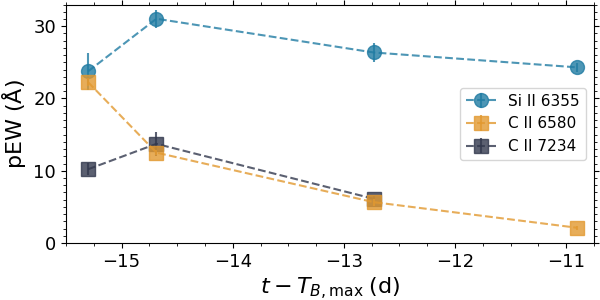

In [29]:
# pEW plot
fig, ax = plt.subplots(figsize = (6,3))

phases = np.array(phases)
labels = ["Si II 6355", "C II 6580", "C II 7234"]
for i, col, marker in zip(range(3), 
                          [aam_colors["blue"],aam_colors["mustard"], aam_colors["asphalt"]],
                          ["o", "s", "s"]):
    obs_pEW = np.array([item[i][0] for item in pEWs])
    obs_pEW_err = np.array([item[i][1] for item in pEWs])
    idx = obs_pEW > 3. * obs_pEW_err
    ax.errorbar(phases[idx], obs_pEW[idx], 
                 yerr=obs_pEW_err[idx],
                 label=labels[i],
                 linestyle='--',
                 marker=marker,
                 ms = 10, 
                 alpha=0.8, color = col, zorder = int(3 % (i+1)))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_xlim(-15.5, -10.75)
ax.set_ylim(0,33)
ax.legend(loc="right", numpoints=1, fancybox=True, fontsize=11)
# ax.set_xlabel("Days since B-band max", fontsize=14)
# ax.set_ylabel("Pseudo-Equivalent Width ($\\rm{\\AA}$)", fontsize=14)
ax.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize=16)
ax.set_ylabel(r"pEW ($\mathrm{\AA}$)", fontsize=16)
ax.tick_params(axis='both', which='both', top=True, right=True, labelsize=13)

fig.subplots_adjust(top=0.985, left=0.11, bottom=0.19,right=0.99)
# plt.savefig("pEW.pdf")

In [18]:
# Velocity plot
rest_wave = [6355, 6580, 7234]
vel = dict()
vel_err = dict()
for i in range(3):
    vel[labels[i]] = list()
    vel_err[labels[i]] = list()
    for measurements in center_wavelengths:
        wave, wave_err = measurements[i]
        velocity = (1 - wave / rest_wave[i]) * const.c.to('Mm/s').value # phys.c / 1e8  # kkm/s
        velocity_err = wave_err / rest_wave[i] * const.c.to('Mm/s').value # phys.c / 1e8
        vel[labels[i]].append(velocity)
        vel_err[labels[i]].append(velocity_err)
    vel[labels[i]] = np.array(vel[labels[i]])
    vel_err[labels[i]] = np.array(vel_err[labels[i]])

<IPython.core.display.Javascript object>


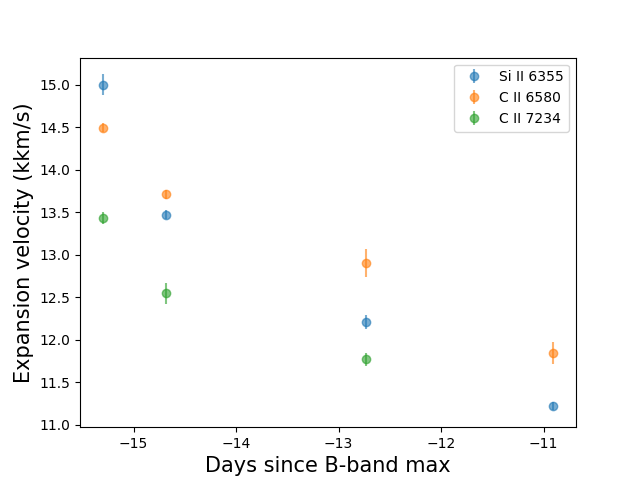

In [7]:
for i in range(3):
    # remove the last measurement in C II 7234
    if i == 2:
        idx = np.arange(0, 3)
    else:
        idx = np.arange(0, 4)
    plt.errorbar(phases[idx], vel[labels[i]][idx], 
                 yerr=vel_err[labels[i]][idx],
                 marker='o',
                 linestyle='none',
                 alpha=0.6,
                 label=labels[i])
plt.legend(loc="upper right")
plt.xlabel("Days since B-band max", fontsize=15)
plt.ylabel("Expansion velocity (kkm/s)", fontsize=15)

In [27]:
spectra[13].telescope

'Keck-I'

<IPython.core.display.Javascript object>


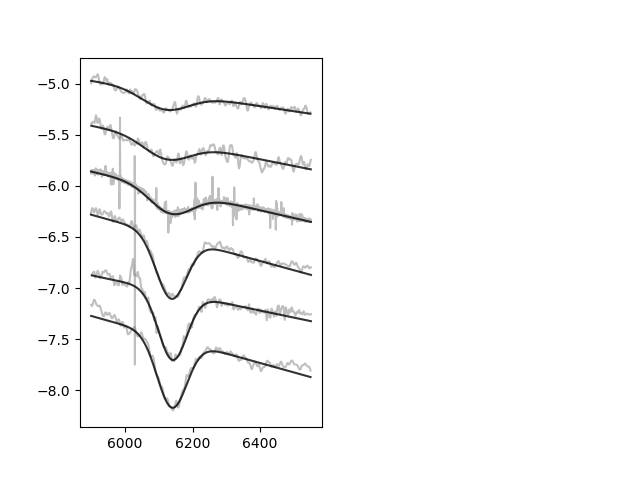

Si II 6355: phase= -9.8, center=6122.3 +/- 1.8, sigma=68.7 +/- 2.4, intensity=26.7 +/- 1.1
Si II 6355: phase= -7.8, center=6126.4 +/- 2.8, sigma=67.2 +/- 3.6, intensity=27.0 +/- 1.7
Si II 6355: phase= -7.2, center=6138.6 +/- 0.8, sigma=62.8 +/- 0.9, intensity=31.8 +/- 0.5
Si II 6355: phase= +3.7, center=6138.4 +/- 0.4, sigma=44.6 +/- 0.5, intensity=56.5 +/- 0.5
Si II 6355: phase= +6.3, center=6142.0 +/- 0.9, sigma=42.1 +/- 1.0, intensity=60.2 +/- 1.3
Si II 6355: phase= +8.5, center=6140.4 +/- 0.6, sigma=43.6 +/- 0.6, intensity=61.3 +/- 0.8


In [30]:
additional_phase = list()
additional_vel = list()
additional_vel_err = list()

fig = plt.figure()
fig.subplots_adjust(wspace=0.05)
ax = fig.add_subplot(1, 2, 1)
for i in [5, 7, 8, 10, 11, 12]:
    spec = spectra[i]
    wv = spec.data["wavelength"]
    flx = spec.data["flux"]
    idx = np.logical_and(wv > 5900, wv < 6550)
    if np.sum(idx) < 20:
        continue
    ax.plot(wv[idx], flx[idx] / np.median(flx[idx]) + offset, color='gray', alpha=0.5, zorder=3)
    popt, pcov = FitSpec(spec, 
                         OneGaussianModel, 
                         [0, 0, 6150, 50, 0.2], 
                         lambda_range=[5900, 6550])
    model_flx = OneGaussianModel(wv[idx], *popt)
    ax.plot(wv[idx], model_flx / np.median(model_flx) + offset, color='k', alpha=0.8, zorder=5)
    
    # Si II 6355
    center = popt[2]
    center_err = pcov[2][2]**0.5
    width = popt[3]
    width_err = pcov[3][3]**0.5
    intensity = popt[4]
    intensity_err = pcov[4][4]**0.5
    center_measure = [(center, center_err)]
    pEW_measure = [(intensity, intensity_err)]
    print("Si II 6355: phase=%+5.1f, center=%.1f +/- %.1f, sigma=%.1f +/- %.1f, intensity=%.1f +/- %.1f" %\
        ((spec.MJD - T_MAX)/(1+z), center, center_err, width, width_err, intensity, intensity_err))
    
    additional_phase.append((spec.MJD - T_MAX)/(1+z))
    additional_vel.append((1 - center / rest_wave[0]) * const.c.to('Mm/s').value) #phys.c / 1e8)
    additional_vel_err.append(center_err / rest_wave[0] * const.c.to('Mm/s').value) #phys.c / 1e8)
    offset -= 0.5

In [35]:
with open("SiII_velocities.dat", "w") as fw:
    for phase, v, v_unc in zip(np.concatenate([phases, additional_phase]),
                               np.concatenate([vel["Si II 6355"], additional_vel]),
                               np.concatenate([vel_err["Si II 6355"], additional_vel_err])):
        print(phase, v, v_unc, file=fw)

<IPython.core.display.Javascript object>


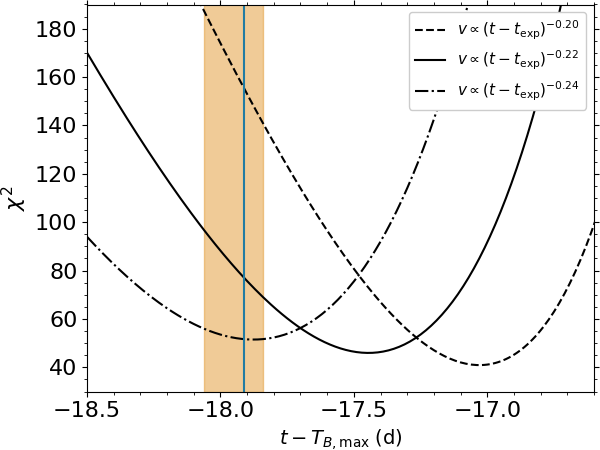

For power-law index -0.20:
                T0 = -17.03 + (0.06,0.12,0.18) - (0.07,0.14,0.21)
                at a 68%, 95%, 99.7% confidence interval
For power-law index -0.22:
                T0 = -17.45 + (0.07,0.14,0.21) - (0.08,0.16,0.24)
                at a 68%, 95%, 99.7% confidence interval
For power-law index -0.24:
                T0 = -17.88 + (0.08,0.15,0.23) - (0.09,0.18,0.27)
                at a 68%, 95%, 99.7% confidence interval


In [47]:
cat_phases = np.concatenate([phases, additional_phase[0:3]])
cat_vel = np.concatenate([vel["Si II 6355"], additional_vel[0:3]])
cat_vel_err = np.concatenate([vel_err["Si II 6355"], additional_vel_err[0:3]])

fig, ax = plt.subplots(figsize = (6,4.5))
t_range = np.linspace(-18.5, -16.5, 201)
chi2 = np.ndarray(t_range.shape)


for pli, ls in zip([-0.20, -0.22, -0.24], ["--", "-", "-."]):
    for i in range(len(t_range)):
        t0 = t_range[i]
        x = (cat_phases - t0)**(pli)
        c = np.sum(x * cat_vel / cat_vel_err**2) / np.sum(x * x/ cat_vel_err**2)
        chi2[i] = np.sum(((c * x - cat_vel) / (cat_vel_err))**2)
    ax.plot(t_range, chi2, 'k', linestyle = ls, 
            label=r"$v\propto (t-t_\mathrm{{{:s}}})^{{{:.2f}}}$".format("exp", pli))
    idx = np.argmin(chi2)
    chi2 -= np.min(chi2)
    prob = np.exp(-chi2 / 2)
    cumprob = np.cumsum(prob)/sum(prob)
    up68 = t_range[np.argmin(np.abs(cumprob - 0.84))] - t_range[idx]
    low68 = t_range[idx] - t_range[np.argmin(np.abs(cumprob - 0.16))]
    up95 = t_range[np.argmin(np.abs(cumprob - 0.975))] - t_range[idx]
    low95 = t_range[idx] - t_range[np.argmin(np.abs(cumprob - 0.025))]
    up997 = t_range[np.argmin(np.abs(cumprob - 0.9985))] - t_range[idx]
    low997 = t_range[idx] - t_range[np.argmin(np.abs(cumprob - 0.0015))]


    print("""For power-law index {:.2f}:
                T0 = {:.2f} + ({:.2f},{:.2f},{:.2f}) - ({:.2f},{:.2f},{:.2f})
                at a 68%, 95%, 99.7% confidence interval""".format(pli, t_range[idx], 
                                                       up68, up95, up997,
                                                       low68, low95, low997))

    if pli == -0.22:
        T0 = t_range[np.argmin(chi2)]
    
# for i in range(len(t_range)):
#     t0 = t_range[i]
#     x = (cat_phases - t0)**(-0.20)
#     c = np.sum(x * cat_vel / cat_vel_err**2) / np.sum(x * x/ cat_vel_err**2)
#     chi2[i] = np.sum(((c * x - cat_vel) / cat_vel_err)**2)
# ax.plot(t_range, chi2, 'k--', label="$v\\propto (t-t_{exp})^{-0.20}$")

# for i in range(len(t_range)):
#     t0 = t_range[i]
#     x = (cat_phases - t0)**(-0.22)
#     c = np.sum(x * cat_vel / cat_vel_err**2) / np.sum(x * x/ cat_vel_err**2)
#     chi2[i] = np.sum(((c * x - cat_vel) / cat_vel_err)**2)
# ax.plot(t_range, chi2, 'k-', label="$v\\propto (t-t_{exp})^{-0.22}$")
# T0 = t_range[np.argmin(chi2)]

# for i in range(len(t_range)):
#     t0 = t_range[i]
#     x = (cat_phases - t0)**(-0.24)
#     c = np.sum(x * cat_vel / cat_vel_err**2) / np.sum(x * x/ cat_vel_err**2)
#     chi2[i] = np.sum(((c * x - cat_vel) / cat_vel_err)**2)
# ax.plot(t_range, chi2, 'k-.', label="$v\\propto (t-t_{exp})^{-0.24}$")

ax.set_xlim(-18.5,-16.6)
ax.set_ylim(30, 190)
y_min, y_max = plt.ylim()
ax.plot([-17.91, -17.91], [y_min, y_max], color = aam_colors["blue"])
ax.fill_between([-18.06, -17.84], y1=y_min, y2=y_max, color=aam_colors["mustard"], alpha=0.5, zorder=1)
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(5))

# ax.set_xlabel("Explosion Time (days)", fontsize=14)
ax.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize=14)
ax.set_ylabel("$\\chi^2$", fontsize=16)
ax.tick_params(axis='both', which='both', top=True, right=True, labelsize=16)
ax.legend(loc='upper right', framealpha = 1,fontsize = 11)


fig.tight_layout()
fig.subplots_adjust(left = 0.145, bottom = 0.13, right = 0.99, top = 0.99)

# fig.savefig("Chi2.pdf")

<IPython.core.display.Javascript object>


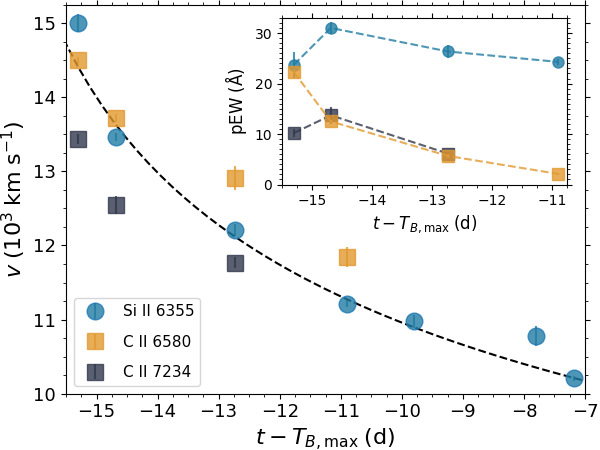

-17.45


In [56]:
fig, ax = plt.subplots(figsize = (6,4.5))
# ax.set_xscale("log", nonposx='clip')
# ax.set_yscale("log", nonposy='clip')

print(T0)
ax.errorbar(cat_phases, cat_vel, 
            yerr=cat_vel_err, 
            marker='o',
            markerfacecolor=aam_colors["blue"],
            markersize=12,
            linestyle='none', 
            label="Si II 6355",
            alpha=0.8)

for i, col in zip(range(1, 3), [aam_colors["mustard"],aam_colors["asphalt"]] ):
    # remove the last measurement in C II 7234
    if i == 2:
        idx = np.arange(0, 3)
    else:
        idx = np.arange(0, 4)
    ax.errorbar(phases[idx], vel[labels[i]][idx], 
                 yerr=vel_err[labels[i]][idx],
                 marker='s',
                 markersize=12,
                 linestyle='none',
                 alpha=0.8,
                 label=labels[i],
                 color = col)
ax.legend(loc="upper right")

x = (cat_phases - T0)**(-0.22)
c = np.sum(x * cat_vel / cat_vel_err**2) / np.sum(x * x/ cat_vel_err**2)
t = np.linspace(1, 20, 100)
ax.plot(t + T0, c * t**(-0.22), 'k--')
ax.set_xlim(-15.5, -7)
ax.set_ylim(10, 15.25)
# ax.set_xticks([1, 5, 10])
# ax.set_xticklabels(["1", "5", "10"])
# ax.set_yticks([10, 15, 20])
# ax.set_yticklabels(["10", "15", "20"])
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax.set_xlabel("$t - T_{B, \mathrm{max}} \; (\mathrm{d})$", fontsize=16)
ax.set_ylabel("$v \; (10^3 \; \mathrm{km \; s}^{-1})$", fontsize=16)
ax.tick_params(axis='both', which='both', top=True, right=True, labelsize=13)
ax.legend(loc=3, numpoints=1, fancybox=True, labelspacing = 1, fontsize=11)

# inset with the pEW
axinset = fig.add_axes([.47, .59, .475, .37])
phases = np.array(phases)
labels = ["Si II 6355", "C II 6580", "C II 7234"]
for i, col, marker in zip(range(3), 
                          [aam_colors["blue"],aam_colors["mustard"], aam_colors["asphalt"]],
                          ["o", "s", "s"]):
    obs_pEW = np.array([item[i][0] for item in pEWs])
    obs_pEW_err = np.array([item[i][1] for item in pEWs])
    idx = obs_pEW > 3. * obs_pEW_err
    axinset.errorbar(phases[idx], obs_pEW[idx], 
                 yerr=obs_pEW_err[idx],
                 label=labels[i],
                 linestyle='--',
                 marker=marker,
                 ms = 8, 
                 alpha=0.8, color = col, zorder = int(3 % (i+1)))
axinset.xaxis.set_minor_locator(MultipleLocator(0.25))
axinset.yaxis.set_minor_locator(MultipleLocator(1))
axinset.set_xlim(-15.5, -10.75)
axinset.set_ylim(0,33)
axinset.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize=12)
axinset.set_ylabel(r"pEW ($\mathrm{\AA}$)", fontsize=12)
axinset.tick_params(axis='both', which='both', top=True, right=True, labelsize=10)

fig.subplots_adjust(left = 0.11, right = 0.975, top = 0.99, bottom = 0.125)
# plt.savefig("VelocityPlot.pdf")

<IPython.core.display.Javascript object>


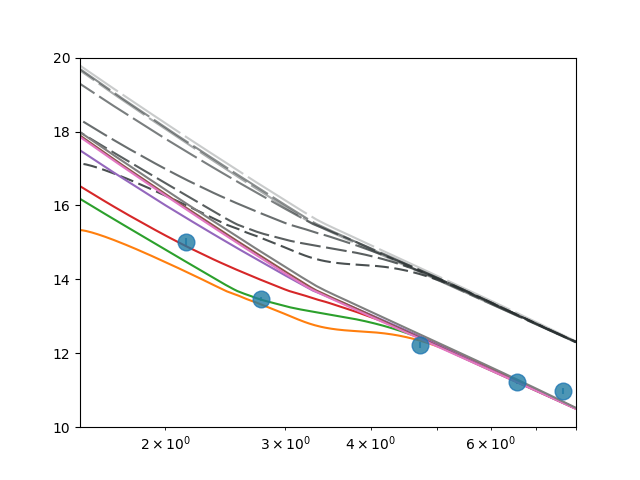

In [32]:
AAMcolors = {'Ni_models': "#2A3132",
             'g': "LightSeaGreen", 
             'UVW2-V': "#061283", # ultramarine
             'UVW1-V': "#00CFAA", # cyan
             'U-V': "#4897D8", # electric blue
             'B-V': "#89DA59", # spring green
             'g-r': "#F9DC24", # sunset #F77604", # caviar
             'r-i': "#FF0038"  # ripe tomato
            }

fig, ax = plt.subplots()

ax.errorbar(cat_phases - T0, cat_vel, 
            yerr=cat_vel_err, 
            marker='o',
            markerfacecolor=aam_colors["blue"],
            markersize=12,
            linestyle='none', 
            label="Si II 6355",
            alpha=0.8)

base_file = "Piro_models/velocities/vel_photo_{:s}.dat"
for mixing in [0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25]:
    dat = Table.read(base_file.format(str(mixing)), format = "ascii", names = ("Time", "Vel"))
    ax.plot(dat["Time"]/86400, dat["Vel"]/1e8, 
             c = AAMcolors['Ni_models'], 
             alpha = 1 - mixing*3,
#              label = r'${:s} \; M_\odot$'.format(str(mixing)),
             dashes = [mixing*100, 2])
    ax.plot(dat["Time"]/86400, dat["Vel"]/1e8 - 1.8) #,
#              alpha = 1 - mixing*3,
#              label = r'${:s} \; M_\odot$'.format(str(mixing)),
#              dashes = [mixing*100, 2])



    
ax.set_xlim(1.5,8)
ax.set_ylim(10,20)
ax.set_xscale('log')